# Notebook to analyse integrated xenopus scRNA-seq datasets

## Imports

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#import scvelo as scv
from scipy import stats
import os
import matplotlib
import pickle
%matplotlib inline
import palantir
import harmony

from IntegratedAnalysis import plot_gene_expression

import random
np.random.seed(0)
random.seed(0)

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


## Settings

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
sc.settings.verbosity = 0  

# Load data

In [6]:

def save_intermediate_files(datasets, temp_dir, file_name_template, identifier):
    for d in datasets:
        file = os.path.join('.', temp_dir, file_name_template + '_' + d.obs[identifier][0] + '.h5ad')
        d.write(file, compression='gzip')
        
identifiers = ['st08','st10.5','st12','st13','st16','st18','st20','st22','st24','st27']
      
def load_intermediate_files(temp_dir, file_name_template, identifiers):
    ob_list = []
    for i in identifiers:
        file = os.path.join('.', temp_dir, file_name_template + '_' + i+ '.h5ad')
        ob_list.append(sc.read_h5ad(file))
    return ob_list

### Harmony discrete timeseries alignment

In [8]:
from Integrate import concat_for_harmony, adata_to_df

In [9]:
timepoints = ['st08', 'st10.5', 'st12', 'st13', 'st16', 'st18', 'st20', 'st22', 'st24', 'st27']
adatas = load_intermediate_files( '../intermediate_files', 'zUMI_raw_singlets' , timepoints)
counts = concat_for_harmony(adatas, timepoints)
norm_df = harmony.utils.normalize_counts(counts)
hvg_genes = harmony.utils.hvg_genes(norm_df, no_genes=2000)
data_df = harmony.utils.log_transform(norm_df.loc[:,hvg_genes])




st08
st10.5
st12
st13
st16
st18
st20
st22
st24
st27
Concatenating data..


In [10]:
#Make cluster colorsfor integrated dataset
colors = [
[(0.3388235294117647, 0.7117262591311034, 0.40584390618992694),0, 2],
[(0.7371472510572856, 0.895517108804306, 0.7108342945021145),1, 4],
[(0.5573241061130334, 0.8164244521337947, 0.546958861976163),2, 3],
[(0.7364705882352941, 0.08, 0.10117647058823528),3, 9],
[(0.7777777777777778, 0.7777777777777778, 0.7777777777777778),4, 1],
[(0.8828143021914648, 0.9546943483275664, 0.8621914648212226),5, 5],
[(0.9466666666666667, 0.26823529411764707, 0.19607843137254902),6, 8],
[(0.586082276047674, 0.586082276047674, 0.586082276047674),7, 0],
[(0.996078431372549, 0.8091503267973856, 0.39607843137254906),8, 14],
[(0.7752402921953095, 0.8583006535947711, 0.9368242983467897),9, 10],
[(0.41708573625528644, 0.6806305267204922, 0.8382314494425221),10, 11],
[(0.5513264129181085, 0.537916186082276, 0.7524490580545944),11, 13],
[(0.9874509803921568, 0.5411764705882353, 0.41568627450980394),12, 7],
[(0.1271049596309112, 0.4401845444059977, 0.7074971164936563),13, 12],
[(0.9913725490196079, 0.7913725490196079, 0.7082352941176471),14, 6]]
colors = pd.DataFrame(colors, columns = ['color', 'org_clust', 'clust_order'])

In [11]:

sns.palplot(colors.sort_values('clust_order').color)

In [12]:
spring = pd.read_csv('../embeddings/SPRING_integrated_coordinates.txt', header = None, index_col = 0)
spring.columns = ['x', 'y']
spring.index = counts.index

In [13]:

tp = pd.Series(index=data_df.index)
for t in timepoints:
    cells = data_df.index[data_df.index.str.contains(t)]
    tp[cells] = t

In [11]:
#Load affinity matrix
with open('../intermediate_files/aug_aff', "rb") as f:
    aug_aff = pickle.load( f)

In [12]:
#Diffusion maps for palantir
dm_res = palantir.utils.run_diffusion_maps(aug_aff,n_components=20,
    knn=20)
ms_data = palantir.utils.determine_multiscale_space(dm_res)
ms_data.index = data_df.index

In [13]:
#Magic imputation
imp_df = palantir.utils.run_magic_imputation(norm_df, dm_res)

In [14]:
#Search by gene id
def find(gene):
    return list(imp_df.columns[imp_df.columns.str.match(r'^(gene[0-9]+\|){}'.format(gene))])

In [15]:
import sys
sys.path.append('../Integrated_analysis/')
from IntegratedAnalysis import plot_gene_expression


In [18]:
b_mark = pd.read_csv('Basal_subset_markers.txt', sep = '\t')

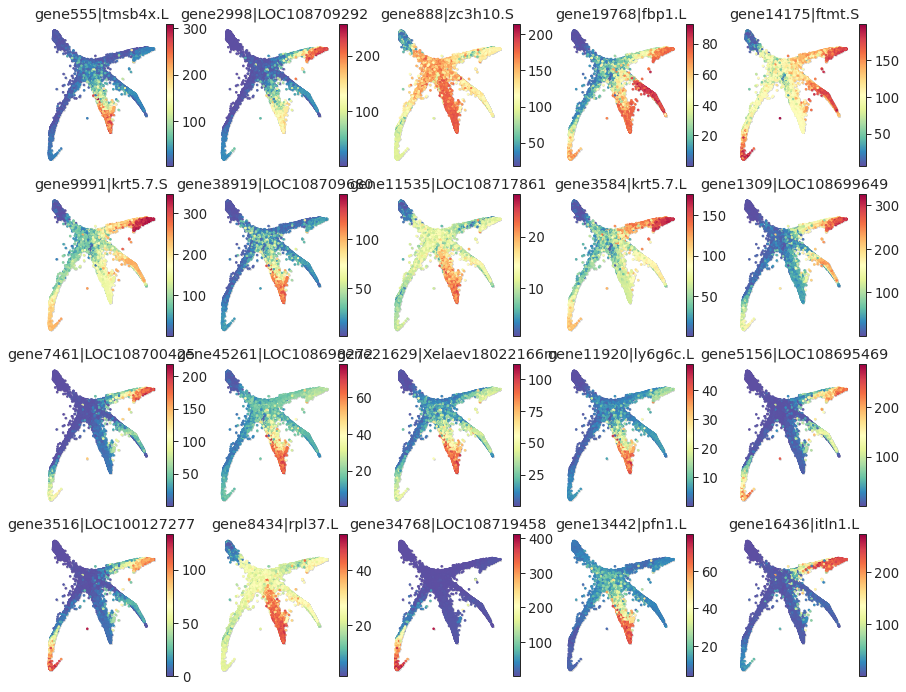

In [30]:
plot_gene_expression(imp_df, spring, b_mark['3'][:20], plot_scale=True)

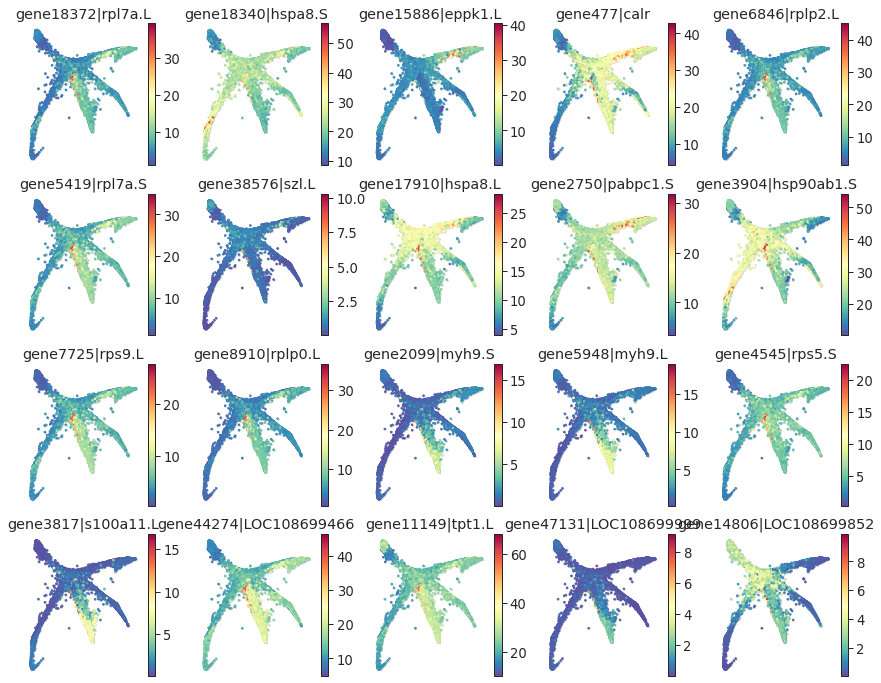

In [31]:
plot_gene_expression(imp_df, spring, b_mark['6'][:20], plot_scale=True)

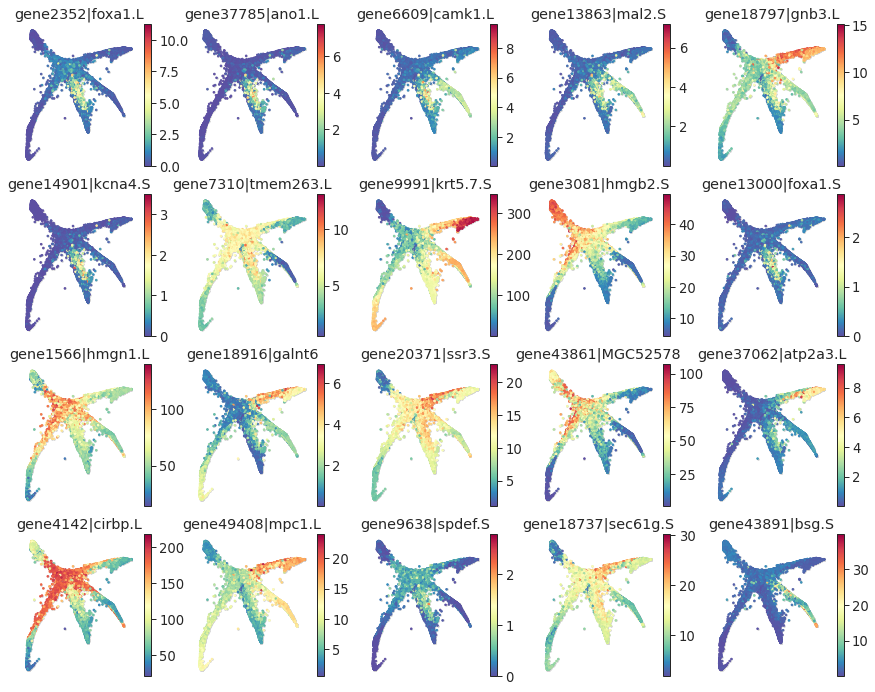

In [32]:
plot_gene_expression(imp_df, spring, b_mark['12'][:20], plot_scale=True)

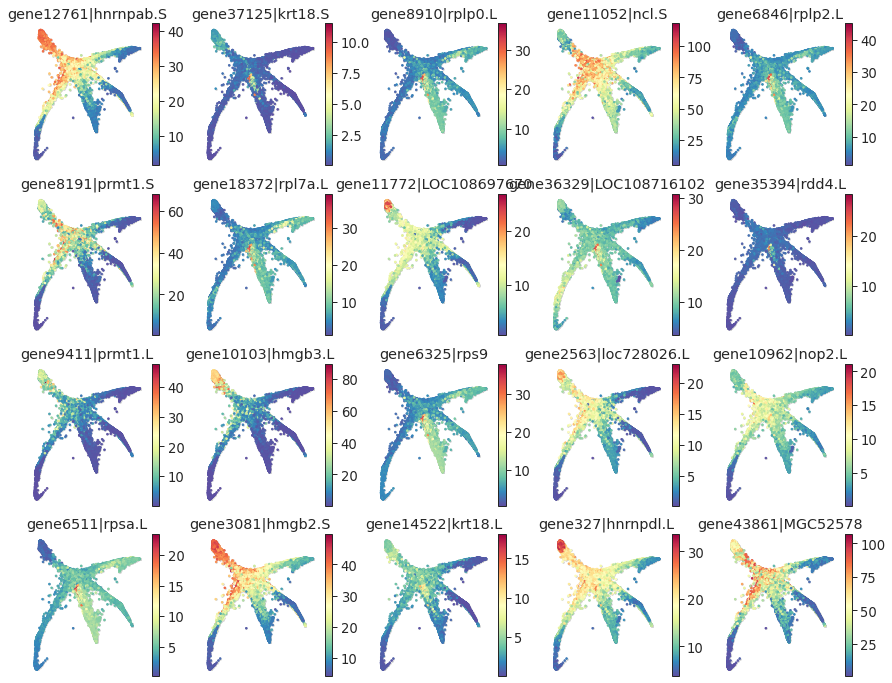

In [33]:
plot_gene_expression(imp_df, spring, b_mark['14'], plot_scale=True)

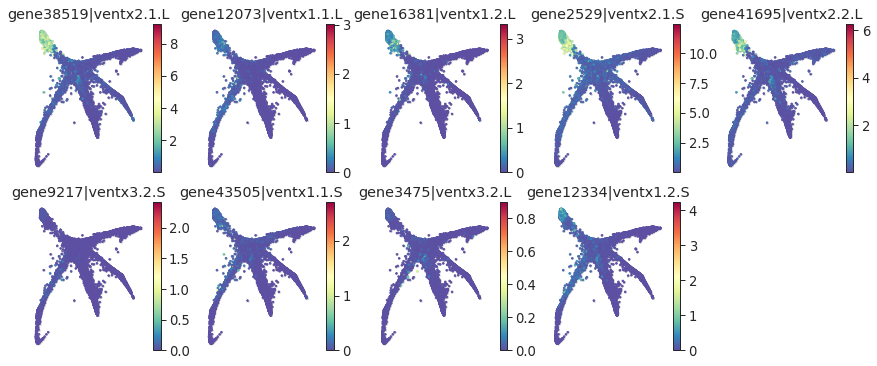

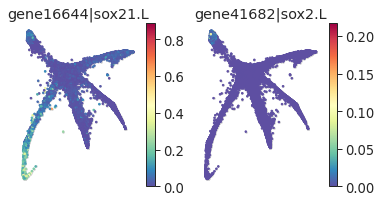

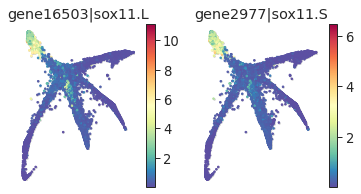

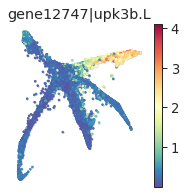

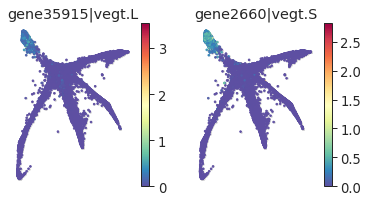

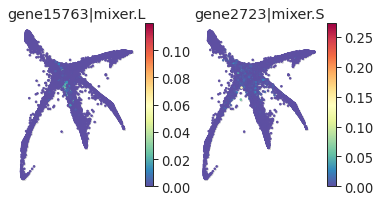

In [40]:
plot_gene_expression(imp_df, spring, find('ventx'), plot_scale=True)
plot_gene_expression(imp_df, spring, find('sox2'), plot_scale=True)

plot_gene_expression(imp_df, spring, find('sox11'), plot_scale=True)

plot_gene_expression(imp_df, spring, find('upk3b'), plot_scale=True)

plot_gene_expression(imp_df, spring, find('vegt'), plot_scale=True)
plot_gene_expression(imp_df, spring, find('mix'), plot_scale=True)


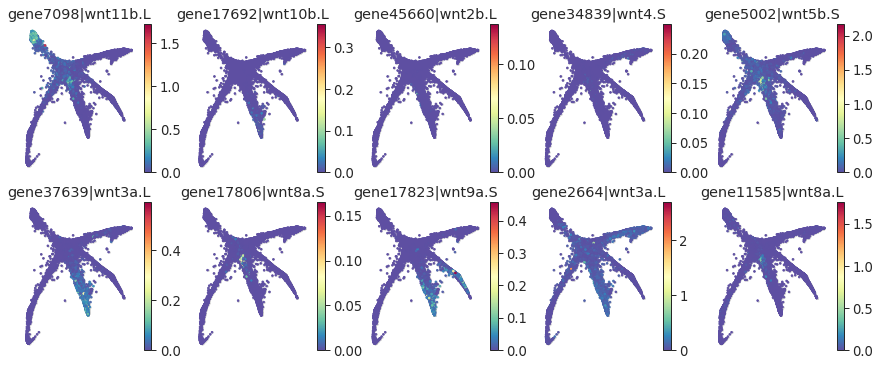

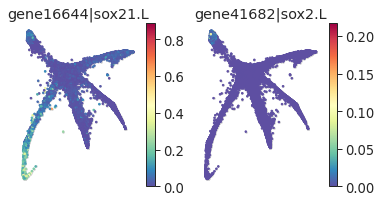

In [41]:
plot_gene_expression(imp_df, spring, find('wnt'), plot_scale=True)
plot_gene_expression(imp_df, spring, find('sox2'), plot_scale=True)


findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


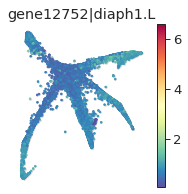

In [17]:
plot_gene_expression(imp_df, spring, ['gene12752|diaph1.L'], plot_scale=True)
#plt.savefig('imputed_diaph1_L_expression.pdf')

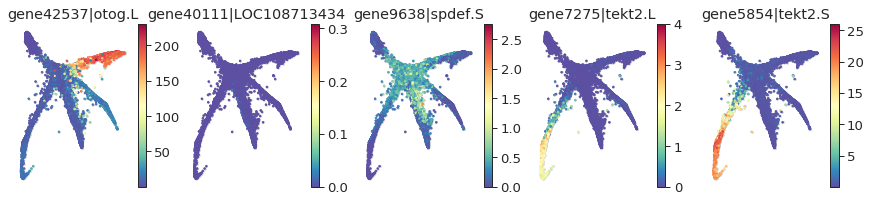

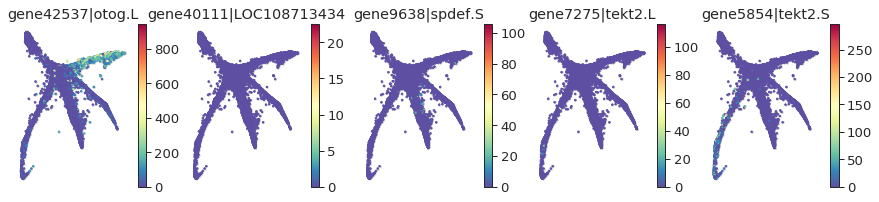

In [35]:

plot_gene_expression(imp_df, spring, ['gene42537|otog.L', 'gene40111|LOC108713434', 'gene9638|spdef.S','gene7275|tekt2.L', 'gene5854|tekt2.S'], plot_scale=True)


plot_gene_expression(norm_df, spring, ['gene42537|otog.L', 'gene40111|LOC108713434', 'gene9638|spdef.S','gene7275|tekt2.L', 'gene5854|tekt2.S'], plot_scale=True)


findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


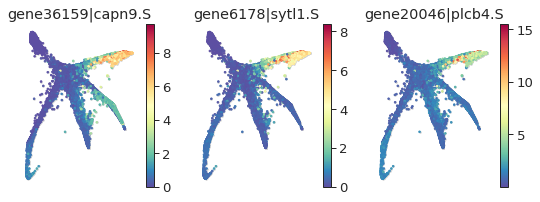

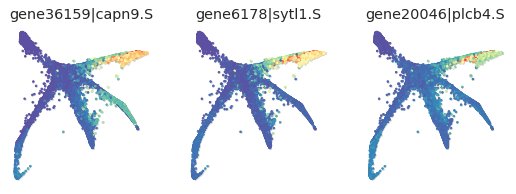

In [18]:
#Goblet branch prob
plot_gene_expression(imp_df, spring, ['gene36159|capn9.S', 'gene6178|sytl1.S', 'gene20046|plcb4.S'], plot_scale=True)
plt.savefig('./intermediate_files/Figures/goblet_branch_prob_scale.pdf',dpi = 500 )
plot_gene_expression(imp_df, spring, ['gene36159|capn9.S', 'gene6178|sytl1.S', 'gene20046|plcb4.S'], plot_scale=False)
plt.savefig('./intermediate_files/Figures/goblet_branch_prob_Noscale.pdf',dpi = 500 )

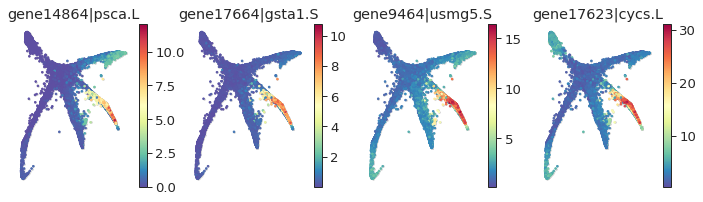

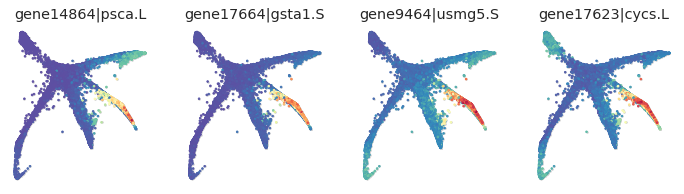

In [61]:
#ionocyte branch prob
plot_gene_expression(imp_df, spring, [ 'gene14864|psca.L', 'gene17664|gsta1.S', 'gene9464|usmg5.S', 'gene17623|cycs.L'], plot_scale=True)
plt.savefig('./intermediate_files/Figures/ion_branch_prob_scale.pdf',dpi = 500 )
plot_gene_expression(imp_df, spring, [ 'gene14864|psca.L', 'gene17664|gsta1.S', 'gene9464|usmg5.S', 'gene17623|cycs.L'], plot_scale=False)
plt.savefig('./intermediate_files/Figures/ion_branch_prob_Noscale.pdf',dpi = 500 )

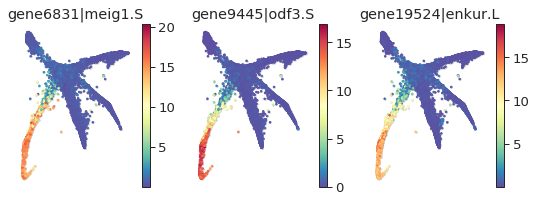

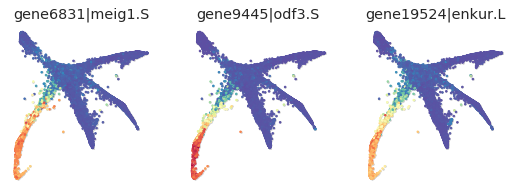

In [62]:
#MCC branch prob
plot_gene_expression(imp_df, spring, ['gene6831|meig1.S', 'gene9445|odf3.S', 'gene19524|enkur.L'], plot_scale=True)
plt.savefig('./intermediate_files/Figures/MCC_branch_prob_scale.pdf',dpi = 500 )
plot_gene_expression(imp_df, spring, ['gene6831|meig1.S', 'gene9445|odf3.S', 'gene19524|enkur.L'], plot_scale=False)
plt.savefig('./intermediate_files/Figures/MCC_branch_prob_Noscale.pdf',dpi = 500 )

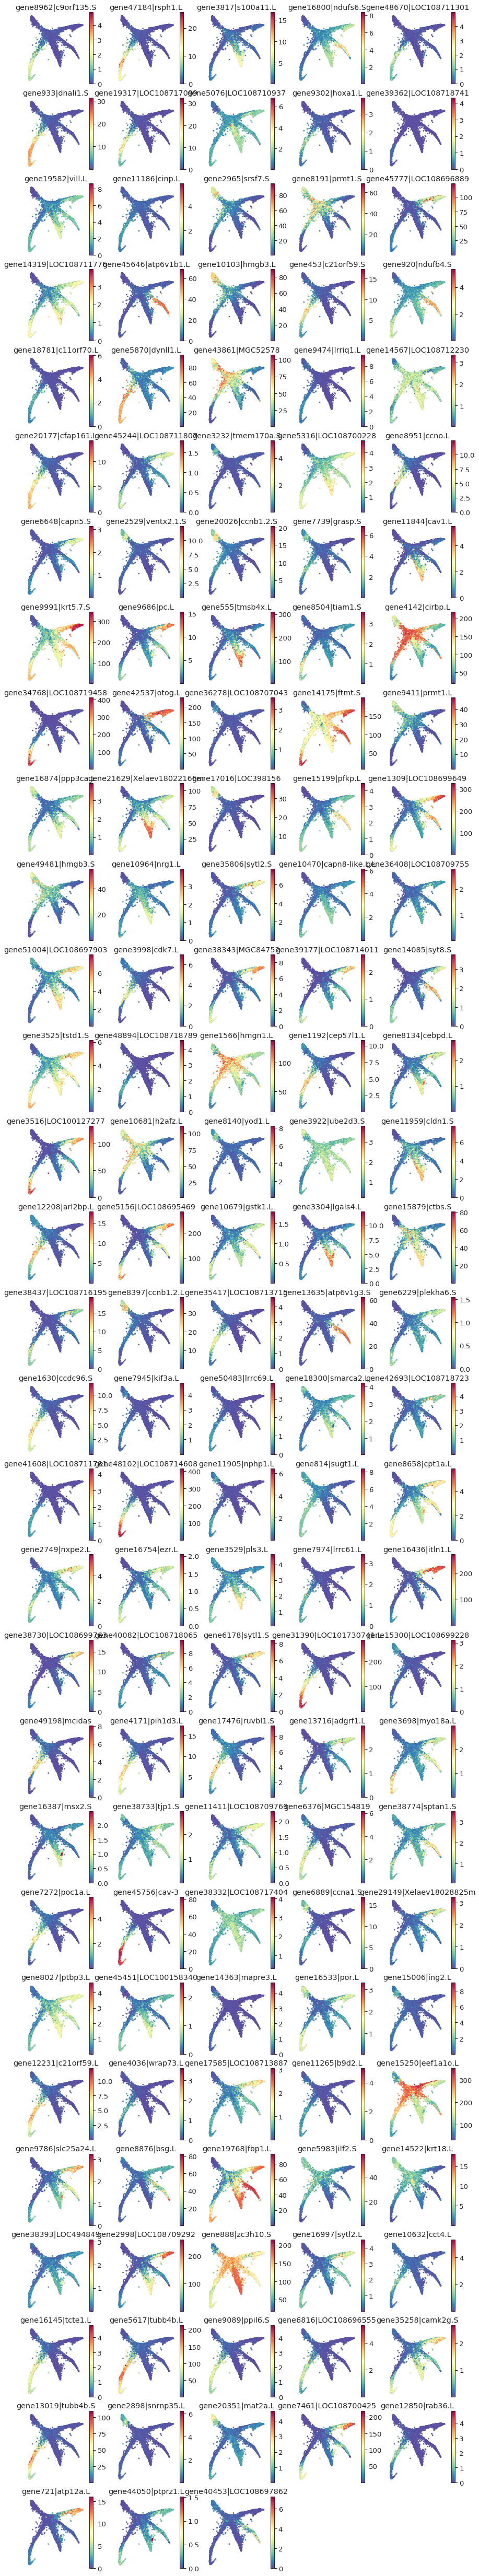

In [54]:
plot_gene_expression(imp_df, spring, 
                                        ['gene8962|c9orf135.S', 'gene47184|rsph1.L', 'gene3817|s100a11.L', 'gene16800|ndufs6.S', 'gene48670|LOC108711301', 'gene933|dnali1.S', 'gene19317|LOC108717099', 'gene5076|LOC108710937', 'gene9302|hoxa1.L', 'gene39362|LOC108718741', 'gene19582|vill.L', 'gene11186|cinp.L', 'gene2965|srsf7.S', 'gene8191|prmt1.S', 'gene45777|LOC108696889', 'gene14319|LOC108711776', 'gene45646|atp6v1b1.L', 'gene10103|hmgb3.L', 'gene453|c21orf59.S', 'gene920|ndufb4.S', 'gene18781|c11orf70.L', 'gene5870|dynll1.L', 'gene43861|MGC52578', 'gene9474|lrriq1.L', 'gene14567|LOC108712230', 'gene20177|cfap161.L', 'gene45244|LOC108711807', 'gene3232|tmem170a.S', 'gene5316|LOC108700228', 'gene8951|ccno.L', 'gene6648|capn5.S', 'gene2529|ventx2.1.S', 'gene20026|ccnb1.2.S', 'gene7739|grasp.S', 'gene11844|cav1.L', 'gene9991|krt5.7.S', 'gene9686|pc.L', 'gene555|tmsb4x.L', 'gene8504|tiam1.S', 'gene4142|cirbp.L', 'gene34768|LOC108719458', 'gene42537|otog.L', 'gene36278|LOC108707043', 'gene14175|ftmt.S', 'gene9411|prmt1.L', 'gene16874|ppp3ca.L', 'gene21629|Xelaev18022166m', 'gene17016|LOC398156', 'gene15199|pfkp.L', 'gene1309|LOC108699649', 'gene49481|hmgb3.S', 'gene10964|nrg1.L', 'gene35806|sytl2.S', 'gene10470|capn8-like.L.L', 'gene36408|LOC108709755', 'gene51004|LOC108697903', 'gene3998|cdk7.L', 'gene38343|MGC84752', 'gene39177|LOC108714011', 'gene14085|syt8.S', 'gene3525|tstd1.S', 'gene48894|LOC108718789', 'gene1566|hmgn1.L', 'gene1192|cep57l1.L', 'gene8134|cebpd.L', 'gene3516|LOC100127277', 'gene10681|h2afz.L', 'gene8140|yod1.L', 'gene3922|ube2d3.S', 'gene11959|cldn1.S', 'gene12208|arl2bp.L', 'gene5156|LOC108695469', 'gene10679|gstk1.L', 'gene3304|lgals4.L', 'gene15879|ctbs.S', 'gene38437|LOC108716195', 'gene8397|ccnb1.2.L', 'gene35417|LOC108713715', 'gene13635|atp6v1g3.S', 'gene6229|plekha6.S', 'gene1630|ccdc96.S', 'gene7945|kif3a.L', 'gene50483|lrrc69.L', 'gene18300|smarca2.L', 'gene42693|LOC108718723', 'gene41608|LOC108711781', 'gene48102|LOC108714608', 'gene11905|nphp1.L', 'gene814|sugt1.L', 'gene8658|cpt1a.L', 'gene2749|nxpe2.L', 'gene16754|ezr.L', 'gene3529|pls3.L', 'gene7974|lrrc61.L', 'gene16436|itln1.L', 'gene38730|LOC108699763', 'gene40082|LOC108718065', 'gene6178|sytl1.S', 'gene31390|LOC101730741.L', 'gene15300|LOC108699228', 'gene49198|mcidas', 'gene4171|pih1d3.L', 'gene17476|ruvbl1.S', 'gene13716|adgrf1.L', 'gene3698|myo18a.L', 'gene16387|msx2.S', 'gene38733|tjp1.S', 'gene11411|LOC108709769', 'gene6376|MGC154819', 'gene38774|sptan1.S', 'gene7272|poc1a.L', 'gene45756|cav-3', 'gene38332|LOC108717404', 'gene6889|ccna1.S', 'gene29149|Xelaev18028825m', 'gene8027|ptbp3.L', 'gene45451|LOC100158340', 'gene14363|mapre3.L', 'gene16533|por.L', 'gene15006|ing2.L', 'gene12231|c21orf59.L', 'gene4036|wrap73.L', 'gene17585|LOC108713887', 'gene11265|b9d2.L', 'gene15250|eef1a1o.L', 'gene9786|slc25a24.L', 'gene8876|bsg.L', 'gene19768|fbp1.L', 'gene5983|ilf2.S', 'gene14522|krt18.L', 'gene38393|LOC494849', 'gene2998|LOC108709292', 'gene888|zc3h10.S', 'gene16997|sytl2.L', 'gene10632|cct4.L', 'gene16145|tcte1.L', 'gene5617|tubb4b.L', 'gene9089|ppil6.S', 'gene6816|LOC108696555', 'gene35258|camk2g.S', 'gene13019|tubb4b.S', 'gene2898|snrnp35.L', 'gene20351|mat2a.L', 'gene7461|LOC108700425', 'gene12850|rab36.L', 'gene721|atp12a.L', 'gene44050|ptprz1.L', 'gene40453|LOC108697862'],
                                       plot_scale=True)
#plt.savefig('LSR_expression_embedding.pdf', dpi = 500)

In [18]:
from IntegratedAnalysis import plot_gene_expression
import palantir

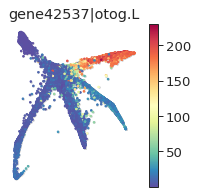

In [30]:
plot_gene_expression(imp_df, spring, ['gene42537|otog.L'],
                                       plot_scale=True)
plt.savefig('otog_expression_imputed.pdf', dpi = 500)

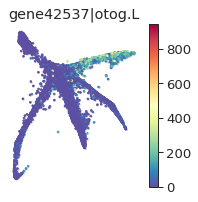

In [31]:
plot_gene_expression(norm_df, spring, ['gene42537|otog.L'],
                                       plot_scale=True)
plt.savefig('otog_expression_norm_counts.pdf', dpi = 500)

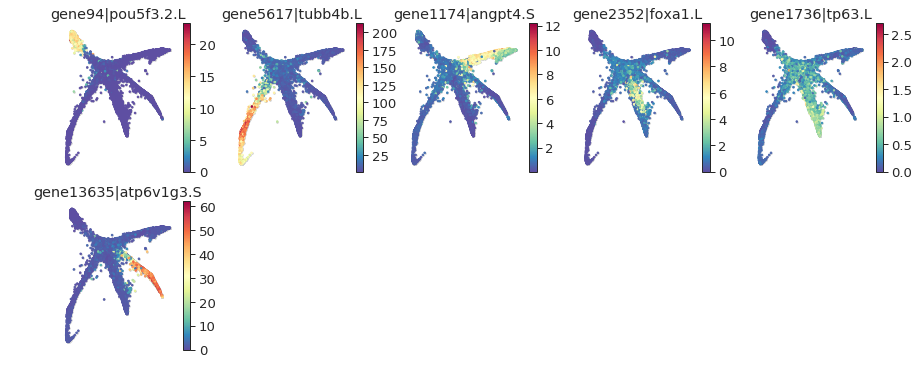

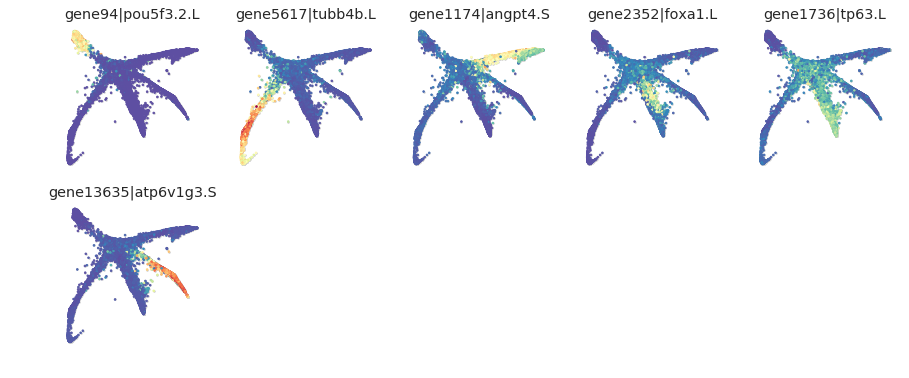

In [117]:
#Plot known markers of cell types
plot_gene_expression(imp_df, spring, 
                                        ['gene94|pou5f3.2.L', 'gene5617|tubb4b.L','gene1174|angpt4.S', 'gene2352|foxa1.L','gene1736|tp63.L', 'gene13635|atp6v1g3.S' ],
                                       plot_scale=True)
plt.savefig('./intermediate_files/Figures/marker_genes_colorbars.pdf',dpi = 500 )
plot_gene_expression(imp_df, spring, 
                                        ['gene94|pou5f3.2.L', 'gene5617|tubb4b.L','gene1174|angpt4.S', 'gene2352|foxa1.L', 'gene1736|tp63.L', 'gene13635|atp6v1g3.S' ],
                                       plot_scale=False)
plt.savefig('./intermediate_files/Figures/marker_genes.pdf',dpi = 500 )

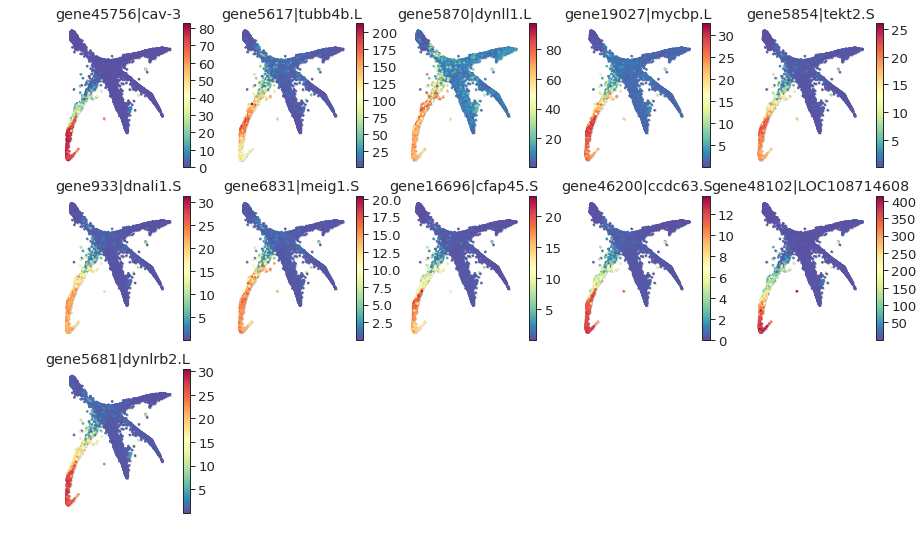

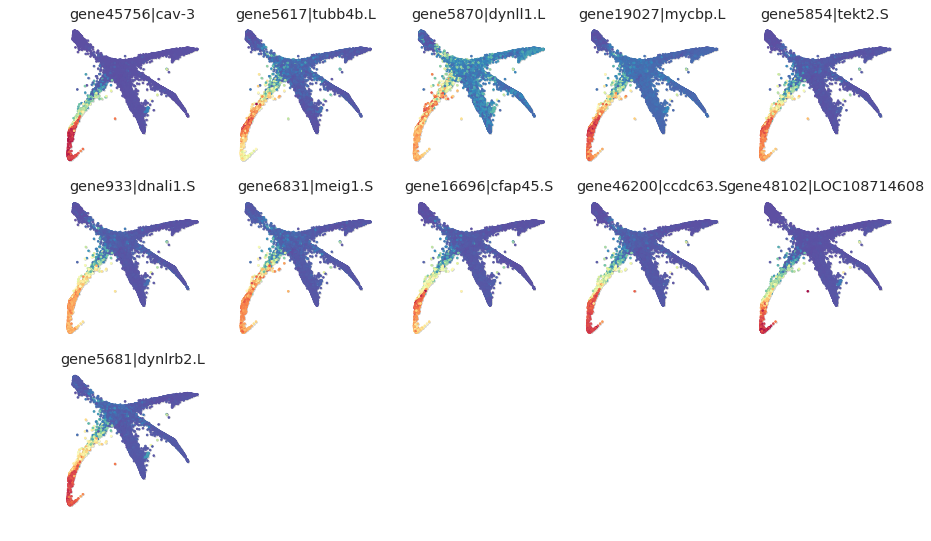

In [121]:
#Plot MCC markers
plot_gene_expression(imp_df, spring, ['gene45756|cav-3', 'gene5617|tubb4b.L','gene5870|dynll1.L', 'gene19027|mycbp.L', 'gene5854|tekt2.S', 'gene933|dnali1.S', 'gene6831|meig1.S', 
                                                    'gene16696|cfap45.S', 'gene46200|ccdc63.S', 'gene48102|LOC108714608', 'gene5681|dynlrb2.L'], plot_scale=True)
plt.savefig('./intermediate_files/Figures/marker_genes_MCC_Scale.pdf'.format(g),dpi = 500 )
plot_gene_expression(imp_df, spring, ['gene45756|cav-3', 'gene5617|tubb4b.L','gene5870|dynll1.L', 'gene19027|mycbp.L', 'gene5854|tekt2.S', 'gene933|dnali1.S', 'gene6831|meig1.S', 
                                                    'gene16696|cfap45.S', 'gene46200|ccdc63.S', 'gene48102|LOC108714608', 'gene5681|dynlrb2.L'], plot_scale=False)
plt.savefig('./intermediate_files/Figures/marker_genes_MCC_NoScale.pdf'.format(g),dpi = 500 )


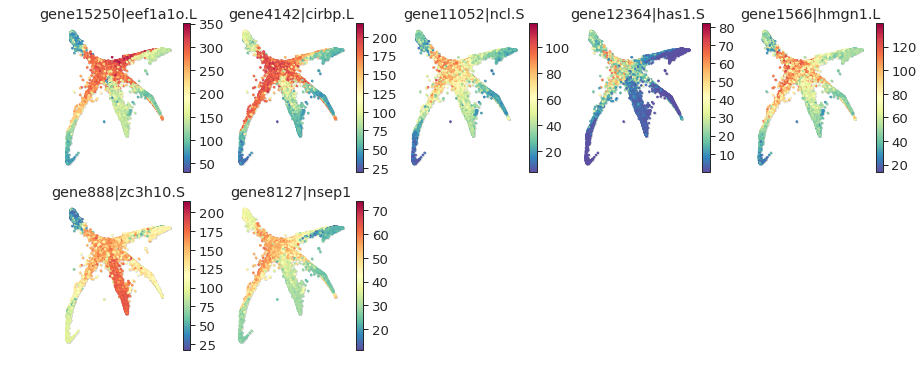

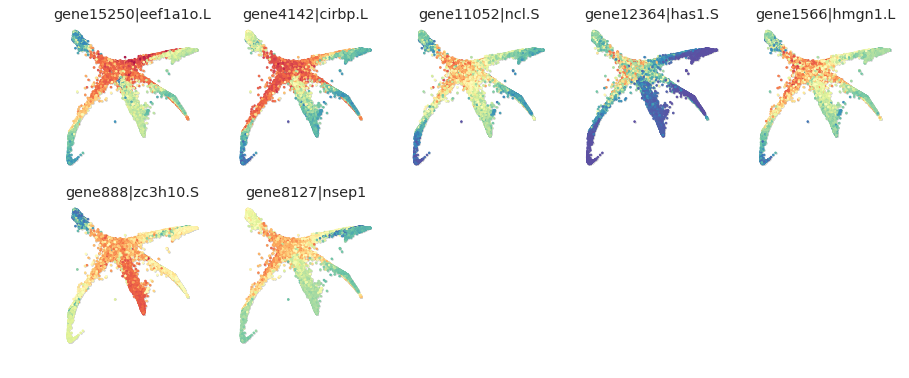

In [122]:
#Plot progenitor markers
plot_gene_expression(imp_df, spring, ['gene15250|eef1a1o.L', 'gene4142|cirbp.L', 'gene11052|ncl.S',
                                                   'gene12364|has1.S', 'gene1566|hmgn1.L', 'gene888|zc3h10.S', 'gene8127|nsep1'], plot_scale=True)
plt.savefig('./intermediate_files/Figures/marker_genes_progenitor_Scale.pdf'.format(g),dpi = 500 )

plot_gene_expression(imp_df, spring, ['gene15250|eef1a1o.L', 'gene4142|cirbp.L', 'gene11052|ncl.S',
                                                   'gene12364|has1.S', 'gene1566|hmgn1.L', 'gene888|zc3h10.S', 'gene8127|nsep1'], plot_scale=False)
plt.savefig('./intermediate_files/Figures/marker_genes_progenitor_NoScale.pdf'.format(g),dpi = 500 )


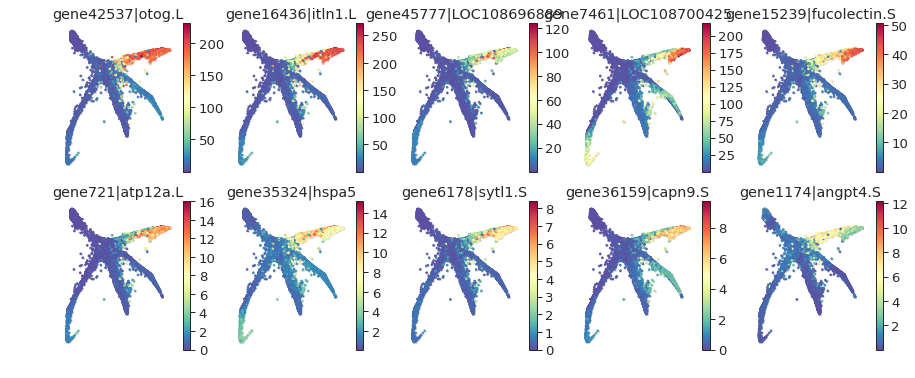

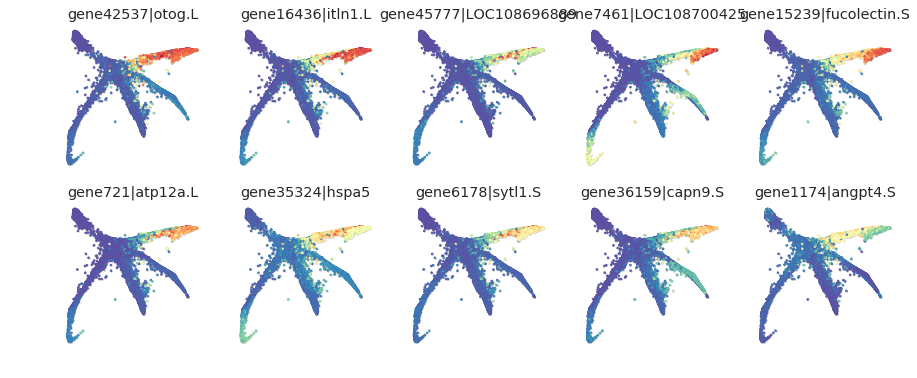

In [123]:
#Plot goblet markers
plot_gene_expression(imp_df, spring, ['gene42537|otog.L', 'gene16436|itln1.L', 'gene45777|LOC108696889',
                                                   'gene7461|LOC108700425', 'gene15239|fucolectin.S', 'gene721|atp12a.L',
                                                   'gene35324|hspa5', 'gene6178|sytl1.S', 'gene36159|capn9.S', 'gene1174|angpt4.S'], plot_scale=True)
plt.savefig('./intermediate_files/Figures/marker_genes_Goblet_Scale.pdf'.format(g),dpi = 500 )

plot_gene_expression(imp_df, spring, ['gene42537|otog.L', 'gene16436|itln1.L', 'gene45777|LOC108696889',
                                                   'gene7461|LOC108700425', 'gene15239|fucolectin.S', 'gene721|atp12a.L',
                                                   'gene35324|hspa5', 'gene6178|sytl1.S', 'gene36159|capn9.S', 'gene1174|angpt4.S'], plot_scale=False)
plt.savefig('./intermediate_files/Figures/marker_genes_Goblet_NoScale.pdf'.format(g),dpi = 500 )



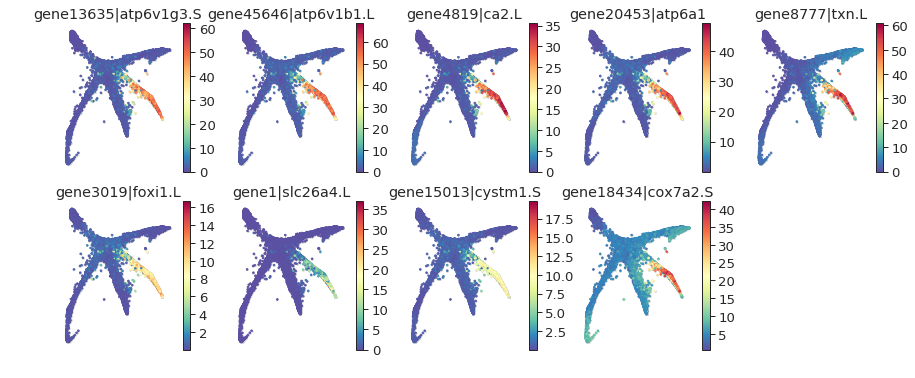

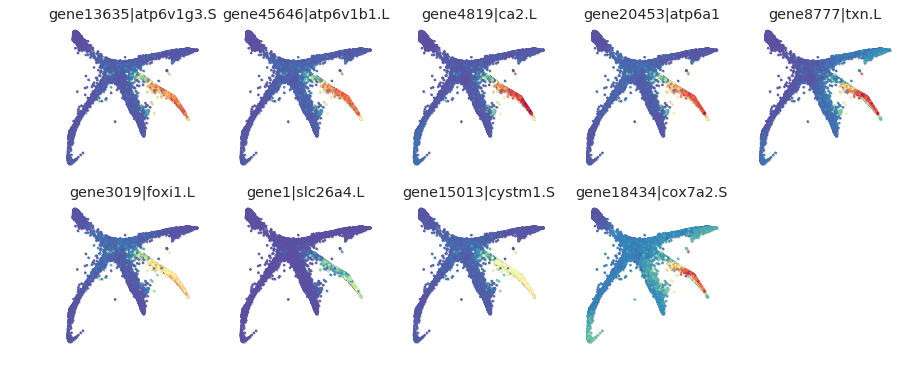

In [124]:
#Plot ionocyte markers
plot_gene_expression(imp_df, spring, ['gene13635|atp6v1g3.S', 'gene45646|atp6v1b1.L', 'gene4819|ca2.L', 
                                                    'gene20453|atp6a1', 'gene8777|txn.L', 'gene3019|foxi1.L', 'gene1|slc26a4.L',
                                                   'gene15013|cystm1.S', 'gene18434|cox7a2.S'], plot_scale=True)
plt.savefig('./intermediate_files/Figures/marker_genes_Ionocyte_Scale.pdf'.format(g),dpi = 500 )


plot_gene_expression(imp_df, spring, ['gene13635|atp6v1g3.S', 'gene45646|atp6v1b1.L', 'gene4819|ca2.L', 
                                                    'gene20453|atp6a1', 'gene8777|txn.L', 'gene3019|foxi1.L', 'gene1|slc26a4.L',
                                                   'gene15013|cystm1.S', 'gene18434|cox7a2.S'], plot_scale=False)
plt.savefig('./intermediate_files/Figures/marker_genes_Ionocyte_NoScale.pdf'.format(g),dpi = 500 )

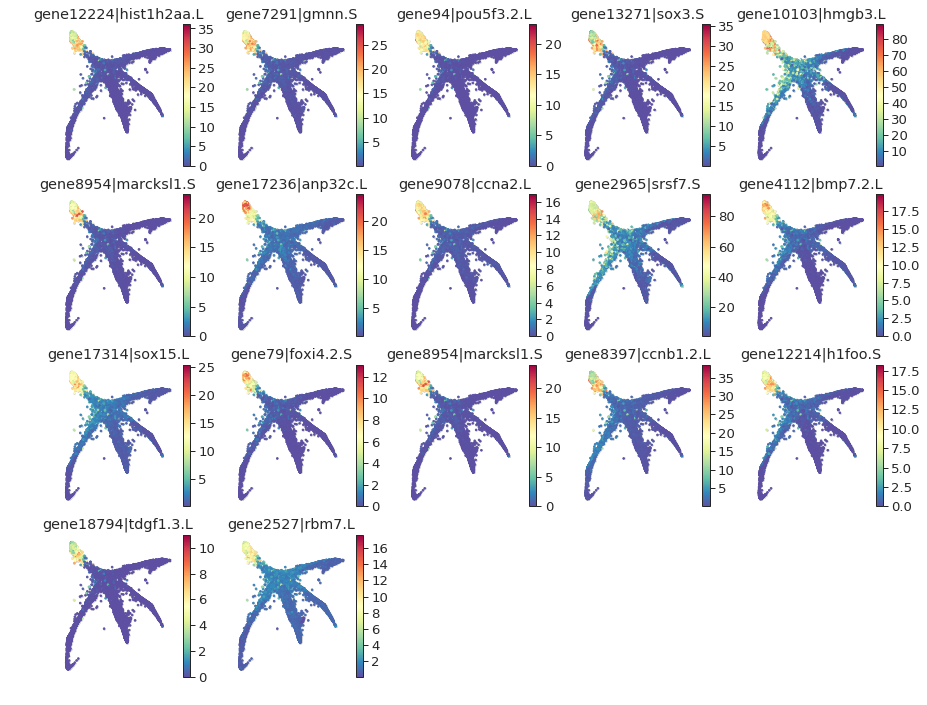

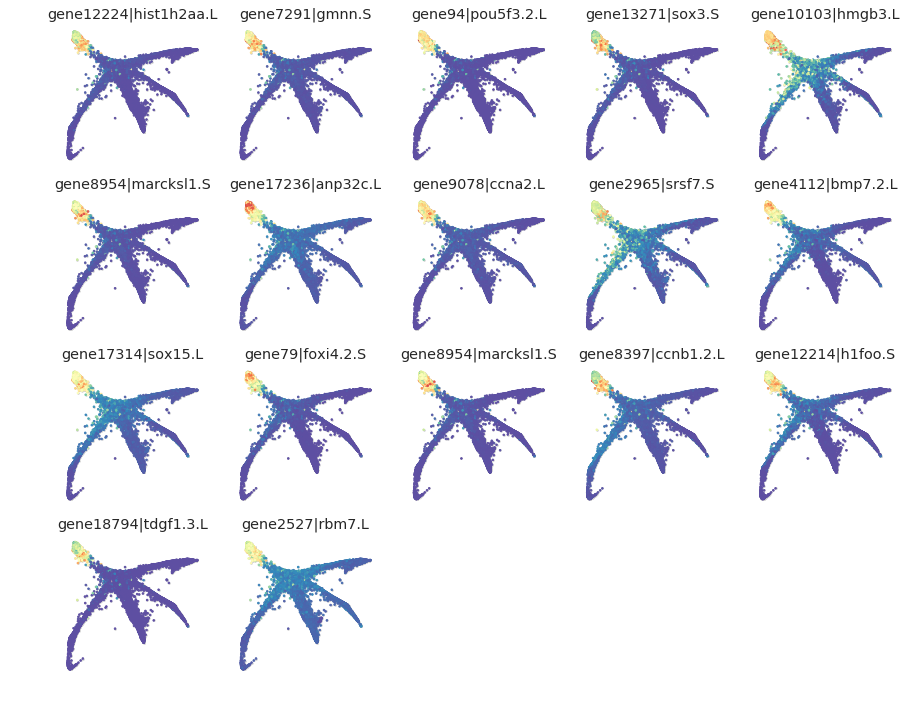

In [125]:
#Plot pluripotent markers
plot_gene_expression(imp_df, spring, ['gene12224|hist1h2aa.L', 'gene7291|gmnn.S', 'gene94|pou5f3.2.L', 'gene13271|sox3.S', 'gene10103|hmgb3.L', 
                                                   'gene8954|marcksl1.S', 'gene17236|anp32c.L', 'gene9078|ccna2.L', 'gene2965|srsf7.S', 'gene4112|bmp7.2.L',
                                                    'gene17314|sox15.L', 'gene79|foxi4.2.S', 'gene8954|marcksl1.S', 'gene8397|ccnb1.2.L', 'gene12214|h1foo.S', 'gene18794|tdgf1.3.L', 
                                                   'gene2527|rbm7.L'], plot_scale=True)
plt.savefig('./intermediate_files/Figures/marker_genes_Pluripotent_Scale.pdf'.format(g),dpi = 500 )

plot_gene_expression(imp_df, spring, ['gene12224|hist1h2aa.L', 'gene7291|gmnn.S', 'gene94|pou5f3.2.L', 'gene13271|sox3.S', 'gene10103|hmgb3.L', 
                                                   'gene8954|marcksl1.S', 'gene17236|anp32c.L', 'gene9078|ccna2.L', 'gene2965|srsf7.S', 'gene4112|bmp7.2.L',
                                                    'gene17314|sox15.L', 'gene79|foxi4.2.S', 'gene8954|marcksl1.S', 'gene8397|ccnb1.2.L', 'gene12214|h1foo.S', 'gene18794|tdgf1.3.L', 
                                                   'gene2527|rbm7.L'], plot_scale=False)
plt.savefig('./intermediate_files/Figures/marker_genes_Pluripotent_NoScale.pdf'.format(g),dpi = 500 )

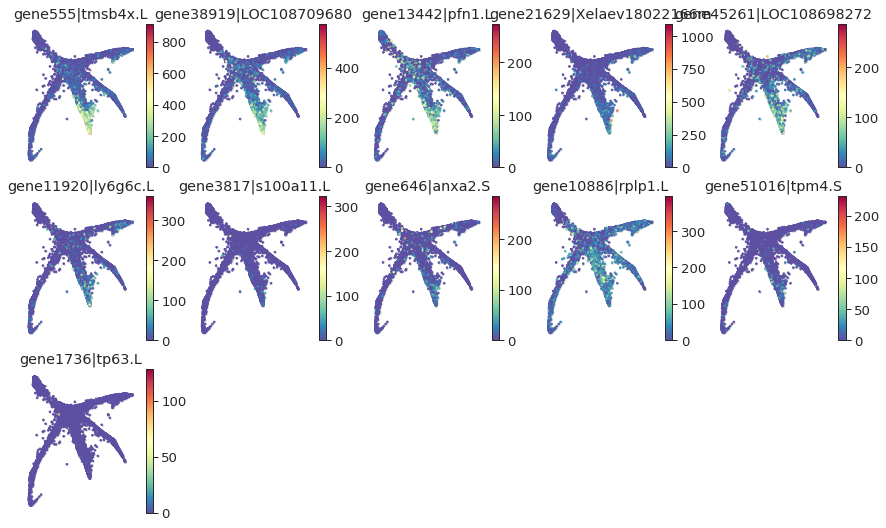

In [24]:
#Plot basal cell markers

plot_gene_expression(imp_df, spring, ['gene555|tmsb4x.L', 'gene38919|LOC108709680', 'gene13442|pfn1.L', 'gene21629|Xelaev18022166m', 
                                                   'gene45261|LOC108698272','gene11920|ly6g6c.L', 'gene3817|s100a11.L', 'gene646|anxa2.S', 'gene10886|rplp1.L', 'gene51016|tpm4.S',
                                                    'gene1736|tp63.L',
                                                   ], plot_scale=True)
plt.savefig('./intermediate_files/Figures/marker_genes_Stem_Scale.pdf'.format(g),dpi = 500 )

plot_gene_expression(imp_df, spring, ['gene555|tmsb4x.L', 'gene38919|LOC108709680', 'gene13442|pfn1.L', 'gene21629|Xelaev18022166m', 
                                                   'gene45261|LOC108698272','gene11920|ly6g6c.L', 'gene3817|s100a11.L', 'gene646|anxa2.S', 'gene10886|rplp1.L', 'gene51016|tpm4.S',
                                                    'gene1736|tp63.L',
                                                   ], plot_scale=False)
plt.savefig('./intermediate_files/Figures/marker_genes_Stem_NoScale.pdf'.format(g),dpi = 500 )


In [78]:
Notch_signling=["jag1.L",
"jag1.S",
"jag2.S",
"jag2.L",
"dll1.L",
"dll1.S",
"dll4.L",
"dlc1.L",
"dlc1.L",
"notch1.S",
"notch2.S",
"notch2.L",
"notch3.S",
"notch3.L",
"notch4.L"]

Notch_TFs=["hes1.L",
"hes1.S",
"hes3.1.L",
"hes3.1.S",
"hes4.L",
"hes7.1.L",
"hes7.1.S",]

WNT_signaling=["Wnt11b.L",
"fzd6.L",
"fzd6.S",
"fzd7.L",
"fzd7.S",
"fzd8.L",
"fzd8.S",
"fzd10.L",
"fzd10.S",
"Wnt6.L",
"Wnt6.S",
"Wnt7b.L",
"Wnt7b.S",
"sfrp2.L",
"sfrp2.S",
"dkk1.L",
"dkk1.S"]

MCC_regulators=["gata2.S",
"gata2.L",
"gata3.S",
"gata3.L"]

TFs=["tp63.S",
"tp63.L",
"foxi1.L",
"foxi1.S",
"ubp1.L",
"ubp1.S",
"dmrt2.L",
"dmrt2.S",
"mcidas.S",
"mcidas.L",
"foxj1.L",
"foxj1.S",
"spdef.S",
"foxa1.L",
"foxa1.S",
"foxq1.S",
"foxq1.L"]

In [94]:
#Search by gene id
def find(gene):
    return list(imp_df.columns[imp_df.columns.str.match(r'^(gene[0-9]+\|){}'.format(gene))])

In [95]:
mapped = [find(gene) for gene in Notch_signling]
to_plot = [x for y in mapped for x in y]

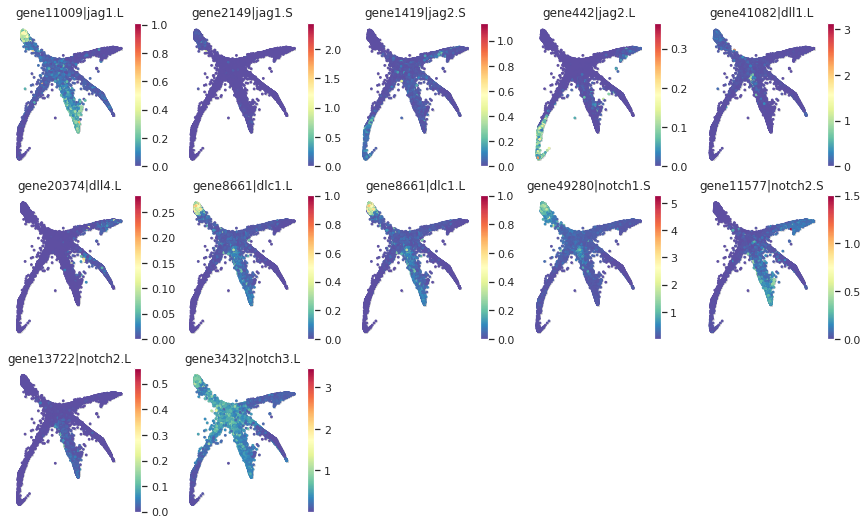

In [96]:
plot_gene_expression(imp_df, spring, to_plot, plot_scale=True)


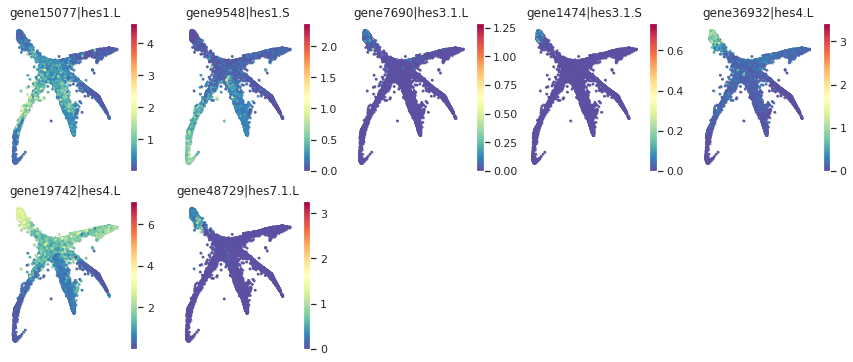

In [93]:
plot_gene_expression(imp_df, spring, to_plot, plot_scale=True)


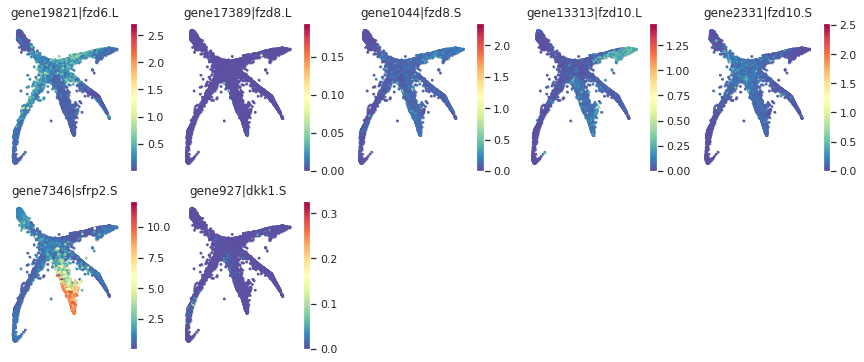

In [90]:
plot_gene_expression(imp_df, spring, to_plot, plot_scale=True)


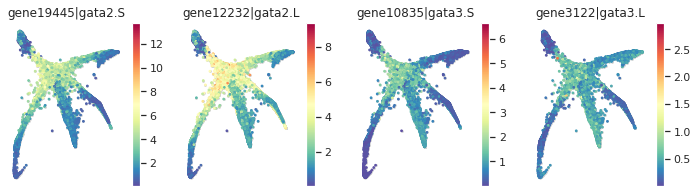

In [87]:
plot_gene_expression(imp_df, spring, to_plot, plot_scale=True)


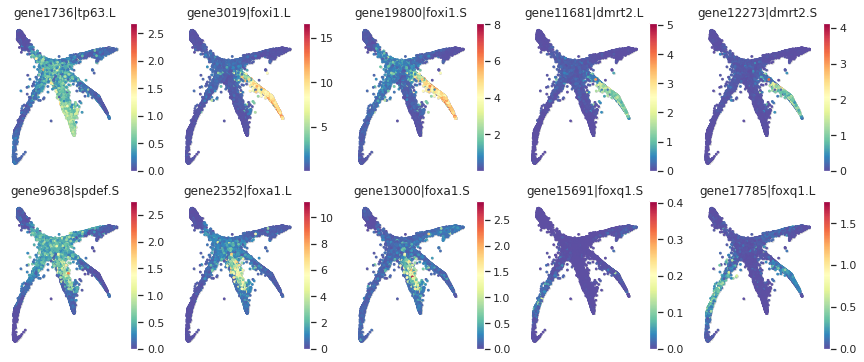

In [84]:
plot_gene_expression(imp_df, spring, to_plot, plot_scale=True)



# Markers by DE

In [35]:
#Make scanpy object
merge = sc.AnnData(counts)

In [37]:
sc.pp.calculate_qc_metrics(merge, percent_top=None, log1p=False, inplace=True)

In [20]:
#Add cluster information obtained from notebook "Integrated_Palantir"

import pickle
   
with open('./intermediate_files/clusters', "rb") as f:
    clusters = pickle.load( f)
    
    
merge.obs['cluster'] = [str(x) for x in clusters.values]

In [21]:
#Standard scanpy processing
sc.pp.filter_genes(merge, min_cells=1, inplace = True)
sc.pp.normalize_per_cell(merge, counts_per_cell_after=1e4)
sc.pp.log1p(merge)

merge.raw = merge
sc.pp.highly_variable_genes(merge, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.scale(merge, max_value=10)



In [22]:
#Subset to highly variable genes
merge = merge[:, merge.var.highly_variable]

In [23]:
#Perfrom louvain on merged dataset #yield 43 clusters
sc.pp.neighbors(merge, n_neighbors = 20)
sc.tl.louvain(merge, resolution=4.5)

In [24]:
def is_mcc(clust):
    if clust == '9' or clust == '10' or clust == '13':
        return 'MCC'
    else:
        return 'non-MCC'

In [25]:
merge.obs['is_mcc'] = [is_mcc(x) for x in merge.obs['cluster'] ]

In [24]:
merge.obs.to_csv('louvain_global_overclust.tsv', sep = '\t', index = False)

In [25]:
#Perfrom louvain on merged dataset #yield 15 clusters
sc.pp.neighbors(merge, n_neighbors = 50)
sc.tl.louvain(merge, resolution=2.1)

In [26]:
len(set(merge.obs.louvain))

16

In [27]:
merge.obs.to_csv('louvain_global.tsv', sep = '\t', index = False)

In [42]:

#Perfrom DE between Phenograph clusters and the rest of the cells
sc.tl.rank_genes_groups(merge, 'is_mcc', method='t-test', n_genes=len(merge.obs_names))

... storing 'is_mcc' as categorical


In [26]:

#Perfrom DE between Phenograph clusters and the rest of the cells
sc.tl.rank_genes_groups(merge, 'cluster', method='t-test', n_genes=len(merge.obs_names))

... storing 'cluster' as categorical
... storing 'is_mcc' as categorical


In [22]:
#Save DE per cluster to files
for cluster in range(0, 15):
    df = pd.DataFrame({'Gene':pd.DataFrame(merge.uns['rank_genes_groups']['names']).iloc[0:, cluster],
             'P-adjust':pd.DataFrame(merge.uns['rank_genes_groups']['pvals_adj']).iloc[0:,cluster],
             'logFC':pd.DataFrame(merge.uns['rank_genes_groups']['logfoldchanges']).iloc[0:,cluster]})
    df.Gene = [x.split('|')[1] for x in df.Gene]
    df.to_csv('Cluster_marker_genes_t-test/Cluster_{}_marker_genes.tsv'.format(cluster), sep = '\t')

In [31]:
DE_genes = {}
for cluster in range(0,15):
    df = pd.read_csv('Cluster_marker_genes_t-test/Cluster_{}_marker_genes.tsv'.format(cluster), sep = '\t', index_col = 0)
    DE_genes[cluster] = df[(df['P-adjust'] < 0.05) & (df['logFC'] > 1)].Gene.tolist()

In [29]:
df = pd.DataFrame(merge.uns['rank_genes_groups']['names']).iloc[0:20]
pd.DataFrame(merge.uns['rank_genes_groups']['names']).iloc[0:100].to_csv('markers.tsv', sep = '\t')